# Exogenous Regressors

> In this notebook, we'll incorporate exogenous regressors to a StatsForecast model. 

::: {.callout-warning collapse="true"}

## Prerequesites

This tutorial assumes basic familiarity with StatsForecast. For a minimal example visit the [Quick Start](../getting-started/1_Getting_Started_short)
:::

## Introduction 

**Exogenous regressors** are variables that can affect the values of a time series. They may not be directly related to the variable that is beging forecasted, but they can still have an impact on it. Examples of exogenous regressors are weather data, economic indicators, or promotional sales. They are typically collected from external sources and by incorporating them into a forecasting model, they can improve the accuracy of our predictions. 

By the end of this tutorial, you'll have a good understanding of how to incorporate exogenous regressors into [StatsForecast](../../models)'s models. Furthermore, you'll see how to evaluate their performance and decide whether or not they can help enhance the forecast. 

**Outline**

1. Install libraries
2. Load and explore the data
3. Split train/test set
4. Add exogenous regressors
5. Create future exogenous regressors
6. Train model 
7. Evaluate results 

::: {.callout-tip}
You can use Colab to run this Notebook interactively <a href="https://colab.research.google.com/github/Nixtla/statsforecast/blob/main/nbs/docs/how-to-guides/Exogenous.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
::: 

## Install libraries

We assume that you have StatsForecast already installed. If not, check this guide for instructions on [how to install StatsForecast](../getting-started/0_Installation).

In [ ]:
# uncomment the following line to install the library
# %pip install statsforecast

In [ ]:
import pandas as pd

## Load and explore the data

In this example, we'll use a single time series from the [M5 Competition](https://www.sciencedirect.com/science/article/pii/S0169207021001187#:~:text=The%20objective%20of%20the%20M5,the%20uncertainty%20around%20these%20forecasts.) dataset. This series represents the daily sales of a product in a Walmart store. The product-store combination that we’ll use in this notebook has `unique_id = FOODS_3_586_CA_3`. This time series was chosen because it is not intermittent and has exogenous regressors that will be useful for forecasting.

We'll load the following dataframes:

- `Y_ts`: (pandas DataFrame) The target time series with columns [`unique_id`, `ds`, `y`]. 
- `X_ts`: (pandas DataFrame) Exogenous time series with columns [`unique_id`, `ds`, exogenous regressors]. 

In [ ]:
base_url = 'https://datasets-nixtla.s3.amazonaws.com'
filters = [('unique_id', '=', 'FOODS_3_586_CA_3')]
Y_ts = pd.read_parquet(f'{base_url}/m5_y.parquet', filters=filters)
X_ts = pd.read_parquet(f'{base_url}/m5_x.parquet', filters=filters)

We can plot the sales of this product-store combination with the `statsforecast.plot` method from the [StatsForecast](../../core#class-statsforecast) class. This method has multiple parameters, and the requiered ones to generate the plots in this notebook are explained below. 

- `df`: A pandas dataframe with columns [`unique_id`, `ds`, `y`].
- `forecasts_df`: A pandas dataframe with columns [`unique_id`, `ds`] and models.
- `engine`: str = `matplotlib`. It can also be `plotly`. `plotly` generates interactive plots, while `matplotlib` generates static plots.

In [ ]:
from statsforecast import StatsForecast 

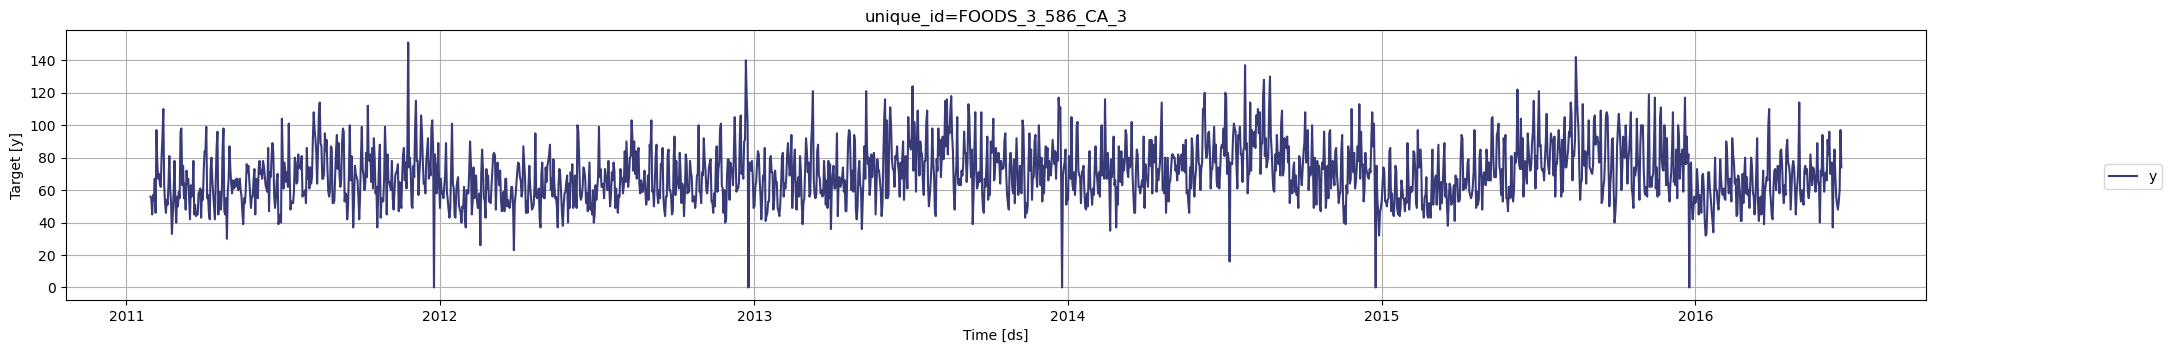

In [ ]:
StatsForecast.plot(Y_ts)

The M5 Competition included several exogenous regressors. Here we'll use the following two.  
    
- `sell_price`: The price of the product for the given store. The price is provided per week. 
- `snap_CA`: A binary variable indicating whether the store allows SNAP purchases (1 if yes, 0 otherwise). SNAP stands for Supplement Nutrition Assitance Program, and it gives individuals and families money to help them purchase food products. 

In [ ]:
X_ts = X_ts[['unique_id', 'ds', 'sell_price', 'snap_CA']]
X_ts.head()

,unique_id,ds,sell_price,snap_CA
0,FOODS_3_586_CA_3,2011-01-29,1.48,0
1,FOODS_3_586_CA_3,2011-01-30,1.48,0
2,FOODS_3_586_CA_3,2011-01-31,1.48,0
3,FOODS_3_586_CA_3,2011-02-01,1.48,1
4,FOODS_3_586_CA_3,2011-02-02,1.48,1


Here the `unique_id` is a category, but for the exogenous regressors it needs to be a string. 

In [ ]:
X_ts['unique_id'] = X_ts.unique_id.astype(str)

We can plot the exogenous regressors using `plotly`. We could use `statsforecast.plot`, but then one of the regressors must be renamed `y`, and the name must be changed back to the original before generating the forecast. 

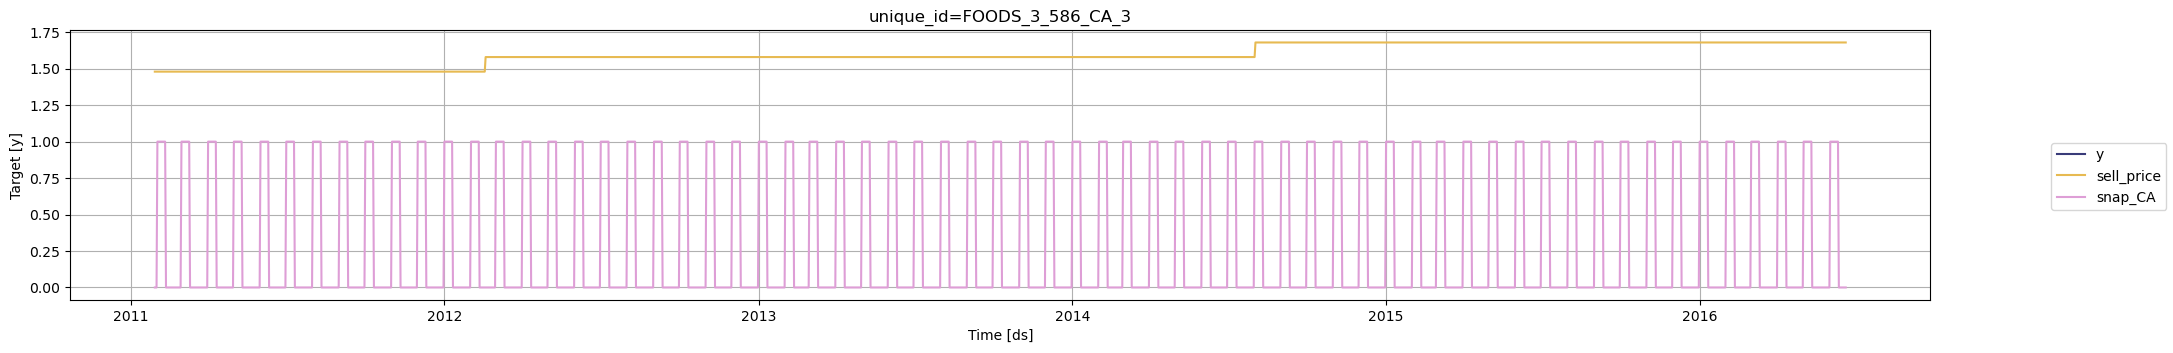

In [ ]:
StatsForecast.plot(Y_ts, X_ts, max_insample_length=0)

From this plot, we can conclude that price has increased twice and that SNAP occurs at regular intervals. 

## Split train/test set 

In the M5 Competition, participants had to forecast sales for the last 28 days in the dataset. We'll use the same forecast horizon and create the train and test sets accordingly. 

In [ ]:
# Extract dates for train and test set 
dates = Y_ts['ds'].unique()
dtrain = dates[:-28]
dtest = dates[-28:]

Y_train = Y_ts.query('ds in @dtrain')
Y_test = Y_ts.query('ds in @dtest') 

X_train = X_ts.query('ds in @dtrain') 
X_test = X_ts.query('ds in @dtest')

## Add exogenous regressors 

The exogenous regressors need to be place after the target variable `y`. 

In [ ]:
train = Y_train.merge(X_ts, how = 'left', on = ['unique_id', 'ds']) 
train.head()

,unique_id,ds,y,sell_price,snap_CA
0,FOODS_3_586_CA_3,2011-01-29,56.0,1.48,0
1,FOODS_3_586_CA_3,2011-01-30,55.0,1.48,0
2,FOODS_3_586_CA_3,2011-01-31,45.0,1.48,0
3,FOODS_3_586_CA_3,2011-02-01,57.0,1.48,1
4,FOODS_3_586_CA_3,2011-02-02,54.0,1.48,1


## Create future exogenous regressors 

We need to include the future values of the exogenous regressors so that we can produce the forecasts. Notice that we already have this information in `X_test`. 

In [ ]:
X_test.head()

,unique_id,ds,sell_price,snap_CA
1941,FOODS_3_586_CA_3,2016-05-23,1.68,0
1942,FOODS_3_586_CA_3,2016-05-24,1.68,0
1943,FOODS_3_586_CA_3,2016-05-25,1.68,0
1944,FOODS_3_586_CA_3,2016-05-26,1.68,0
1945,FOODS_3_586_CA_3,2016-05-27,1.68,0


::: {.callout-important}

If the future values of the exogenous regressors are not available, then they must be forecasted or the regressors need to be eliminated from the model. Without them, it is not possible to generate the forecast. 

:::

## Train model 

To generate the forecast, we'll use [AutoARIMA](https://nixtlaverse.nixtla.io/statsforecast/docs/models/AutoARIMA), which is one of the models available in StatsForecast that allows exogenous regressors. To use this model, we first need to import it from `statsforecast.models` and then we need to instatiate it. Given that we're working with daily data, we need to set `season_length = 7`. 

In [ ]:
from statsforecast.models import AutoARIMA

In [ ]:
# Create a list with the model and its instantiation parameters 
models = [AutoARIMA(season_length=7)]

Next, we need to instantiate a new StatsForecast object, which has the following parameters. 

- `df`: The dataframe with the training data.
- `models`: The list of models defined in the previous step.
- `freq`: A string indicating the frequency of the data. See [pandas’ available frequencies](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases).
- `n_jobs`: An integer that indicates the number of jobs used in parallel processing. Use -1 to select all cores.

In [ ]:
sf = StatsForecast(
    models=models, 
    freq='D', 
    n_jobs=1,
)

Now we're ready to generate the forecast. To do this, we'll use the `forecast` method, which takes the following arguments. 

- `h`: An integer that represents the forecast horizon. In this case, we'll forecast the next 28 days. 
- `X_df`: A pandas dataframe with the future values of the exogenous regressors. 
- `level`:  A list of floats with the confidence levels of the prediction intervals. For example, `level=[95]` means that the range of values should include the actual future value with probability 95%.

In [ ]:
horizon = 28
level = [95]

fcst = sf.forecast(df=train, h=horizon, X_df=X_test, level=level)
fcst.head()

,unique_id,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-hi-95
0,FOODS_3_586_CA_3,2016-05-23,72.956276,44.109070,101.803482
1,FOODS_3_586_CA_3,2016-05-24,71.138611,40.761467,101.515747
2,FOODS_3_586_CA_3,2016-05-25,68.140945,37.550083,98.731804
3,FOODS_3_586_CA_3,2016-05-26,65.485588,34.841637,96.129539
4,FOODS_3_586_CA_3,2016-05-27,64.961441,34.291973,95.630905


We can plot the forecasts with the `statsforecast.plot` method described above. 

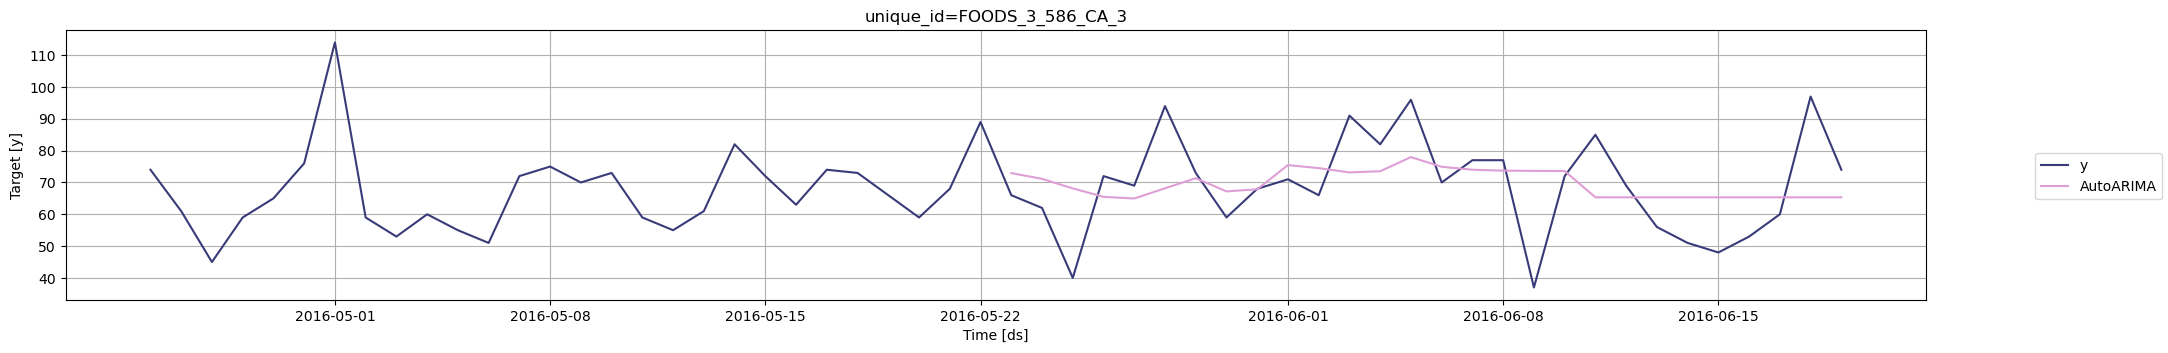

In [ ]:
StatsForecast.plot(Y_ts, fcst, max_insample_length=28*2)

## Evaluate results 

We'll merge the test set and the forecast to evaluate the accuracy using the [mean absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error) (MAE). 

In [ ]:
res = Y_test.merge(fcst, how='left', on=['unique_id', 'ds'])
res.head()

,unique_id,ds,y,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-hi-95
0,FOODS_3_586_CA_3,2016-05-23,66.0,72.956276,44.109070,101.803482
1,FOODS_3_586_CA_3,2016-05-24,62.0,71.138611,40.761467,101.515747
2,FOODS_3_586_CA_3,2016-05-25,40.0,68.140945,37.550083,98.731804
3,FOODS_3_586_CA_3,2016-05-26,72.0,65.485588,34.841637,96.129539
4,FOODS_3_586_CA_3,2016-05-27,69.0,64.961441,34.291973,95.630905


In [ ]:
mae = abs(res['y']-res['AutoARIMA']).mean()
print('The MAE with exogenous regressors is '+str(round(mae,2)))

The MAE with exogenous regressors is 11.42


To check whether the exogenous regressors were useful or not, we need to generate the forecast again, now without them. To do this, we simple pass the dataframe wihtout exogenous variables to the `forecast` method. Notice that the data only includes `unique_id`, `ds`, and `y`. The `forecast` method no longer requieres the future values of the exogenous regressors `X_df`. 

In [ ]:
# univariate model 
fcst_u = sf.forecast(df=train[['unique_id', 'ds', 'y']], h=28)

res_u = Y_test.merge(fcst_u, how='left', on=['unique_id', 'ds'])
mae_u = abs(res_u['y']-res_u['AutoARIMA']).mean()

In [ ]:
print('The MAE without exogenous regressors is '+str(round(mae_u,2)))

The MAE without exogenous regressors is 12.18


Hence, we can conclude that using `sell_price` and `snap_CA` as external regressors helped improve the forecast. 